# Tensorflow 2 Object Detection: Train model



<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Tensorflow-Object-Detection-API-Train-Model/blob/master/Tensorflow_2_Object_Detection_Train_model.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Tensorflow-Object-Detection-API-Train-Model/blob/master/Tensorflow_2_Object_Detection_Train_model.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

This notebook walks you through training a custom object detection model using the Tensorflow Object Detection API and Tensorflow 2.

The notebook is split into the following parts:
* Install the Tensorflow Object Detection API
* Prepare data for use with the OD API
* Write custom training configuration
* Train detector
* Export model inference graph
* Test trained model

![Microcontroller Detection](https://github.com/TannerGilbert/Tensorflow-Object-Detection-API-Train-Model/blob/master/doc/output.png?raw=1)

## Installation

Installing the Tensorflow Object Detection API became a lot easier with the relase of Tensorflow 2. The following few cells are all that is needed in order to install the OD API.

In [4]:
!pip install -U --pre tensorflow=="2.2.0"

  Using cached tensorflow-2.2.0-cp38-cp38-macosx_10_11_x86_64.whl (175.4 MB)
  Using cached tensorflow_estimator-2.2.0-py2.py3-none-any.whl (454 kB)
  Using cached tensorboard-2.2.2-py3-none-any.whl (3.0 MB)
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 0.26.1 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.4.*,<3,

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2797, done.
remote: Counting objects: 100% (2797/2797), done.
remote: Compressing objects: 100% (2439/2439), done.
remote: Total 2797 (delta 563), reused 1415 (delta 322), pack-reused 0
Receiving objects: 100% (2797/2797), 57.73 MiB | 17.76 MiB/s, done.
Resolving deltas: 100% (563/563), done.


In [ ]:
# Install the Object Detection API
%%bash
cd .. #from object_detection folder back to models/research
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1533329 sha256=d7d2f8626d5043591cbc978a05c392b3c73ae89534d2f1a0e3f2ef1338bbc505
  Stored in directory: /tmp/pip-ephem-wheel-cache-5s9aptwv/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl size=20069 sha256=7e02ad8735d4be1fe8292a7f3ecd791ab5438245c60cc96235ad68aec9806ab4
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067c733fba5192f726ad1
Successfully built object-detection py-cpuinfo


object_detection/protos/input_reader.proto: warning: Import object_detection/protos/image_resizer.proto but not used.


In [3]:
#run model builder test
!python3 builders/model_builder_tf2_test.py

Traceback (most recent call last):
  File "builders/model_builder_tf2_test.py", line 24, in <module>
    from object_detection.builders import model_builder
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/object_detection/builders/model_builder.py", line 20, in <module>
    from object_detection.builders import anchor_generator_builder
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/object_detection/builders/anchor_generator_builder.py", line 27, in <module>
    from object_detection.protos import anchor_generator_pb2
ImportError: cannot import name 'anchor_generator_pb2' from 'object_detection.protos' (/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/object_detection/protos/__init__.py)


## Prepare data

To train a robust model, you need a lot of pictures that vary greatly from each other. You can either take the pictures yourself or you can download them from the internet.

After collecting the images you need to label them. For this I recommend using [LabelImg](https://github.com/tzutalin/labelImg) - an free, open source graphical image annotation tool.

![LabelImg](https://raw.githubusercontent.com/tzutalin/labelImg/master/demo/demo3.jpg)

After labeling the images, split the data into a training and testing part and convert the xml label files to csv using the [xml_to_csv.py](https://github.com/TannerGilbert/Tensorflow-Object-Detection-API-Train-Model/blob/master/xml_to_csv.py) script.

I uploaded my Microcontroller Detection data-set on Kaggle. The below four cells are used to download and extract the data-set.

In [ ]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 6.4MB/s 
     |████████████████████████████████| 5.3MB 13.9MB/s 
     |████████████████████████████████| 112kB 60.9MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 122kB 57.3MB/s 


In [ ]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "<username>" 
os.environ['KAGGLE_KEY'] = "<key>"

In [ ]:
!kaggle datasets download -d tannergi/microcontroller-detection --unzip

 60% 5.00M/8.34M [00:00<00:00, 20.5MB/s]
100% 8.34M/8.34M [00:00<00:00, 27.8MB/s]


In [ ]:
!mv "Microcontroller Detection" microcontroller-detection

In [ ]:
!wget https://raw.githubusercontent.com/TannerGilbert/Tensorflow-Object-Detection-API-Train-Model/master/generate_tfrecord.py

--2020-07-18 15:54:55--  https://raw.githubusercontent.com/TannerGilbert/Tensorflow-Object-Detection-API-Train-Model/master/generate_tfrecord.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3382 (3.3K) [text/plain]
Saving to: ‘generate_tfrecord.py’

generate_tfrecord.p 100%[===================>]   3.30K  --.-KB/s    in 0s      

2020-07-18 15:54:55 (53.3 MB/s) - ‘generate_tfrecord.py’ saved [3382/3382]



In [ ]:
!wget https://raw.githubusercontent.com/TannerGilbert/Tensorflow-Object-Detection-API-Train-Model/master/training/labelmap.pbtxt

--2020-07-18 15:54:58--  https://raw.githubusercontent.com/TannerGilbert/Tensorflow-Object-Detection-API-Train-Model/master/training/labelmap.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 177 [text/plain]
Saving to: ‘labelmap.pbtxt’

labelmap.pbtxt      100%[===================>]     177  --.-KB/s    in 0s      

2020-07-18 15:54:58 (12.3 MB/s) - ‘labelmap.pbtxt’ saved [177/177]



In [ ]:
!python generate_tfrecord.py --csv_input=microcontroller-detection/train_labels.csv --image_dir=microcontroller-detection/train --output_path=train.record
!python generate_tfrecord.py --csv_input=microcontroller-detection/test_labels.csv --image_dir=microcontroller-detection/test --output_path=test.record

2020-07-18 15:55:01.284990: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Successfully created the TFRecords: /content/train.record
2020-07-18 15:55:04.972641: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Successfully created the TFRecords: /content/test.record


In [ ]:
train_record_path = '/content/train.record'
test_record_path = '/content/test.record'
labelmap_path = '/content/labelmap.pbtxt'

## Configuring training

Now that the data is ready it's time to create a training configuration. The OD API supports lots of models, each with its own config file. In this notebook I'm making use of EfficientDet, but you can replace it with any model available in the [Tensorflow 2 Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md).

In [ ]:
batch_size = 16
num_steps = 8000
num_eval_steps = 1000

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
!tar -xf efficientdet_d0_coco17_tpu-32.tar.gz

--2020-07-18 15:55:08--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.126.128, 2a00:1450:4013:c01::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.126.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30736482 (29M) [application/x-tar]
Saving to: ‘efficientdet_d0_coco17_tpu-32.tar.gz’

efficientdet_d0_coc 100%[===================>]  29.31M  71.6MB/s    in 0.4s    

2020-07-18 15:55:09 (71.6 MB/s) - ‘efficientdet_d0_coco17_tpu-32.tar.gz’ saved [30736482/30736482]



In [ ]:
fine_tune_checkpoint = 'efficientdet_d0_coco17_tpu-32/checkpoint/ckpt-0'

In [ ]:
!wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config

base_config_path = 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config'

--2020-07-18 15:55:13--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_efficientdet_d0_512x512_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4630 (4.5K) [text/plain]
Saving to: ‘ssd_efficientdet_d0_512x512_coco17_tpu-8.config’

ssd_efficientdet_d0 100%[===================>]   4.52K  --.-KB/s    in 0s      

2020-07-18 15:55:13 (74.9 MB/s) - ‘ssd_efficientdet_d0_512x512_coco17_tpu-8.config’ saved [4630/4630]



In [ ]:
# edit configuration file (from https://colab.research.google.com/drive/1sLqFKVV94wm-lglFq_0kGo2ciM0kecWD)

import re

with open(base_config_path) as f:
    config = f.read()

with open('model_config.config', 'w') as f:
  
  # Set labelmap path
  config = re.sub('label_map_path: ".*?"', 
             'label_map_path: "{}"'.format(labelmap_path), config)
  
  # Set fine_tune_checkpoint path
  config = re.sub('fine_tune_checkpoint: ".*?"',
                  'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), config)
  
  # Set train tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 
                  'input_path: "{}"'.format(train_record_path), config)
  
  # Set test tf-record file path
  config = re.sub('(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 
                  'input_path: "{}"'.format(test_record_path), config)
  
  # Set number of classes.
  config = re.sub('num_classes: [0-9]+',
                  'num_classes: {}'.format(4), config)
  
  # Set batch size
  config = re.sub('batch_size: [0-9]+',
                  'batch_size: {}'.format(batch_size), config)
  
  # Set training steps
  config = re.sub('num_steps: [0-9]+',
                  'num_steps: {}'.format(num_steps), config)
  
  # Set fine-tune checkpoint type to detection
  config = re.sub('fine_tune_checkpoint_type: "classification"', 
             'fine_tune_checkpoint_type: "{}"'.format('detection'), config)
  
  f.write(config)

In [ ]:
%cat model_config.config

 # SSD with EfficientNet-b0 + BiFPN feature extractor,
# shared box predictor and focal loss (a.k.a EfficientDet-d0).
# See EfficientDet, Tan et al, https://arxiv.org/abs/1911.09070
# See Lin et al, https://arxiv.org/abs/1708.02002
# Trained on COCO, initialized from an EfficientNet-b0 checkpoint.
#
# Train on TPU-8

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 4
    add_background_class: false
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      m

In [ ]:
model_dir = 'training/'
pipeline_config_path = 'model_config.config'

## Train detector

In [ ]:
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_config_path} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps={num_eval_steps}

2020-07-18 15:55:18.541351: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-18 15:55:20.730572: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-18 15:55:20.744101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-07-18 15:55:20.744746: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2020-07-18 15:55:20.744782: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-18 15:55:20.746525: I tensorflow/stream_executor/pl

In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/training/train'

<IPython.core.display.Javascript object>

## Export model inference graph

The below code cell adds a line to the tf_utils.py file. This is a temporary fix to a [exporting issue](https://github.com/tensorflow/models/issues/8841) occuring when using the OD API with Tensorflow 2. This code will be removed as soon as the OD Team puts out a fix.

All credit goes to Github user [Jacobsolawetz](https://github.com/Jacobsolawetz), who provided this [temporary fix](https://github.com/tensorflow/models/issues/8841#issuecomment-657647648).

In [1]:
with open('/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/tf_utils.py') as f:
    tf_utils = f.read()

with open('/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/tf_utils.py', 'w') as f:
  # Set labelmap path
  throw_statement = "raise TypeError('Expected Operation, Variable, or Tensor, got ' + str(x))"
  tf_utils = tf_utils.replace(throw_statement, "if not isinstance(x, str):" + throw_statement)
  f.write(tf_utils)

FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/tf_utils.py'

In [ ]:
output_directory = 'inference_graph'

!python3 exporter_main_v2.py \
    --trained_checkpoint_dir training/ckpt-27 \
    --output_directory MyRcnn \
    --pipeline_config_path training/pipeline.config

2020-07-18 18:08:42.450130: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
I0718 18:08:46.165607 140076592244608 ssd_efficientnet_bifpn_feature_extractor.py:144] EfficientDet EfficientNet backbone version: efficientnet-b0
I0718 18:08:46.165880 140076592244608 ssd_efficientnet_bifpn_feature_extractor.py:145] EfficientDet BiFPN num filters: 64
I0718 18:08:46.166004 140076592244608 ssd_efficientnet_bifpn_feature_extractor.py:147] EfficientDet BiFPN num iterations: 3
I0718 18:08:46.182794 140076592244608 efficientnet_model.py:146] round_filter input=32 output=32
2020-07-18 18:08:46.199456: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-18 18:08:46.233530: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
202

In [ ]:
from google.colab import files
files.download(f'/content/{output_directory}/saved_model/saved_model.pb') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test trained model on test images

based on [Object Detection API Demo](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/object_detection_tutorial.ipynb) and [Inference from saved model tf2 colab](https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/inference_from_saved_model_tf2_colab.ipynb).

In [7]:
import io
import os
import scipy.misc
import numpy as np
import six
import time
import glob
from IPython.display import display

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

%matplotlib inline

In [8]:
path = 'images/test/'
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [9]:
category_index = label_map_util.create_category_index_from_labelmap('Test/label_map.pbtxt', use_display_name=True)

In [10]:
tf.keras.backend.clear_session()
print('Loading model...', end='')
start_time = time.time()
model = tf.saved_model.load('MyRcnn/saved_model')
end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 10.889891862869263 seconds


In [11]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  print(num_detections)
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Running inference for images/test/76.jpg... 300


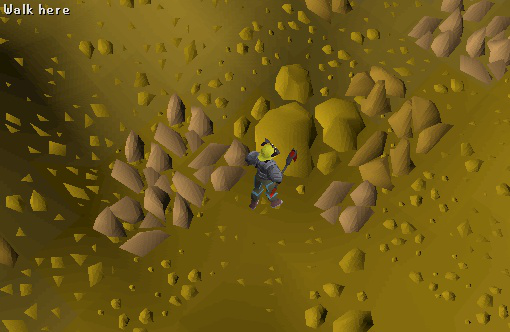

Running inference for images/test/74.jpg... 300


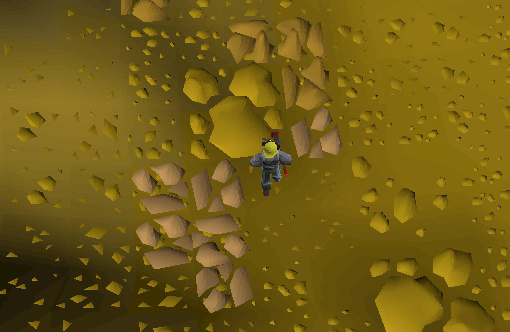

Running inference for images/test/115.jpg... 300


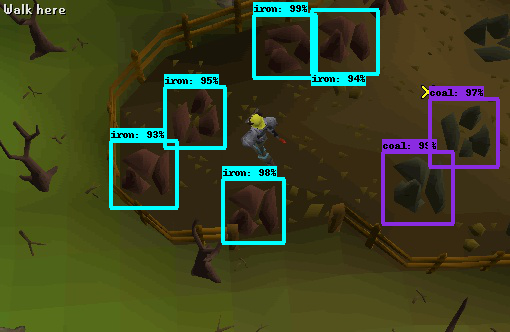

Running inference for images/test/262.jpg... 300


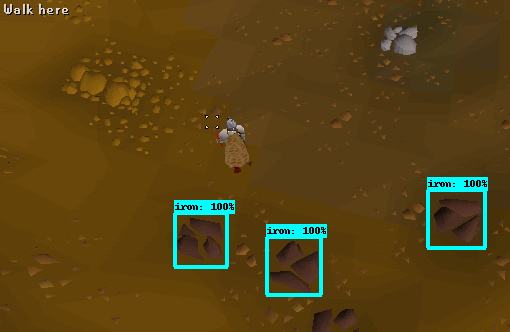

Running inference for images/test/117.jpg... 300


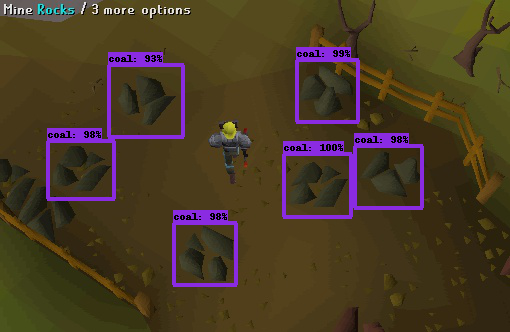

Running inference for images/test/21.jpg... 300


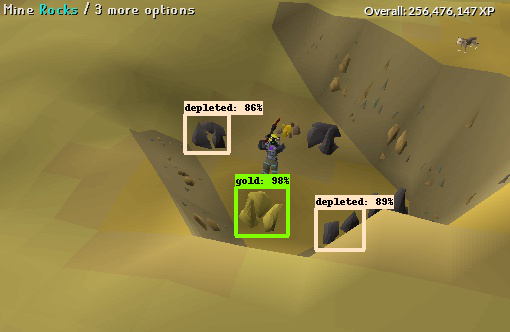

Running inference for images/test/120.jpg... 300


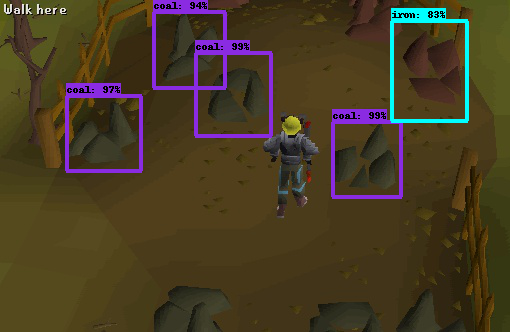

Running inference for images/test/22.jpg... 300


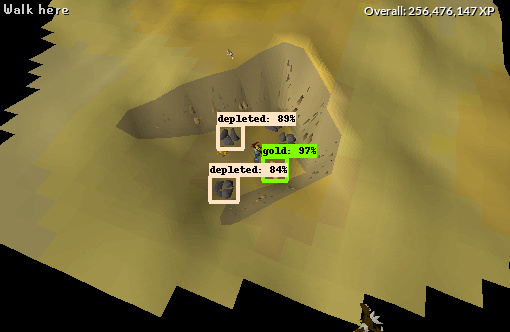

Running inference for images/test/123.jpg... 300


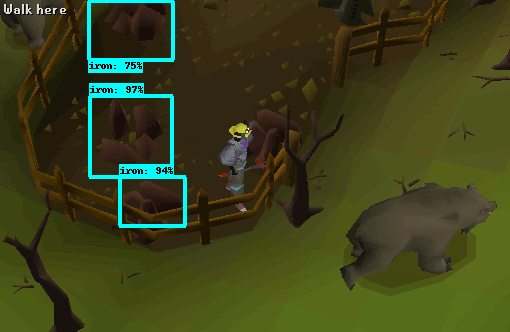

Running inference for images/test/254.jpg... 300


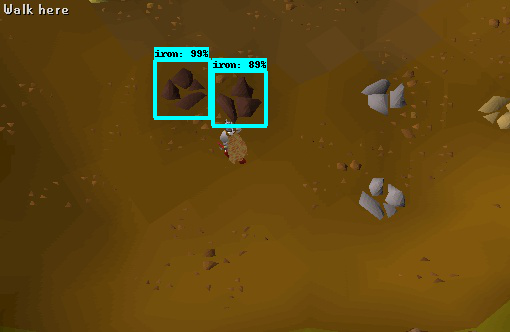

Running inference for images/test/244.jpg... 300


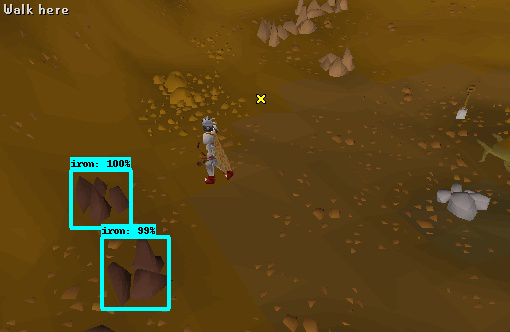

Running inference for images/test/235.jpg... 300


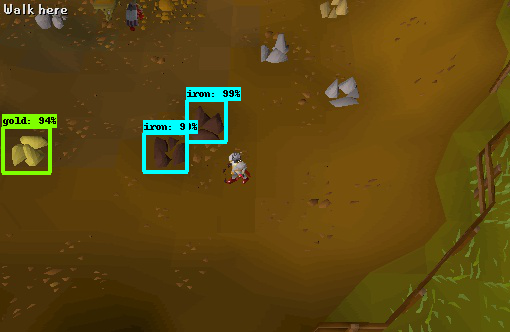

Running inference for images/test/5.jpg... 300


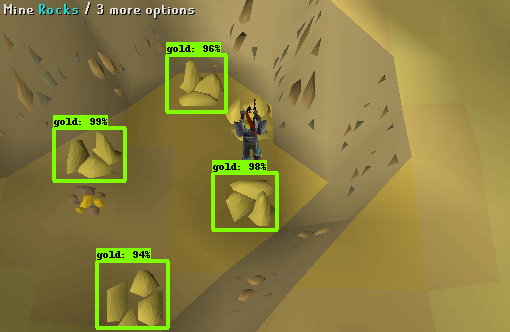

Running inference for images/test/82.jpg... 300


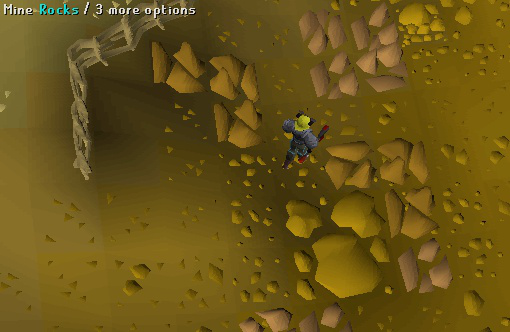

Running inference for images/test/1.jpg... 300


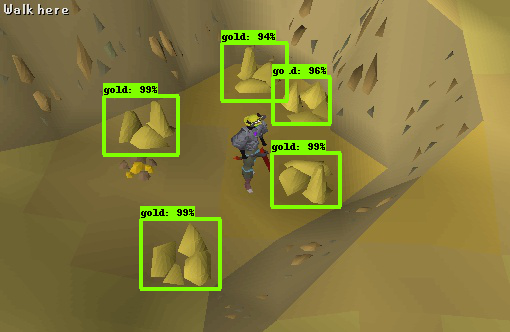

Running inference for images/test/231.jpg... 300


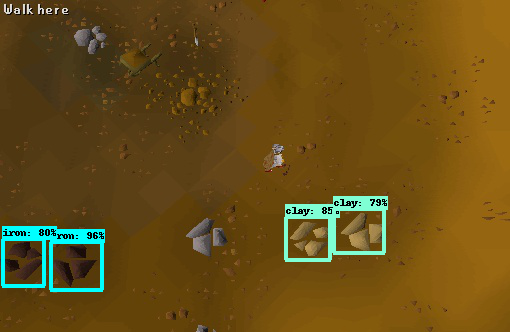

In [13]:
for image_path in glob.glob('images/test/*.jpg'):
  print('Running inference for {}... '.format(image_path), end='')
  image_np = load_image_into_numpy_array(image_path)
  output_dict = run_inference_for_single_image(model, image_np)
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=None,
      use_normalized_coordinates=True,
      agnostic_mode=False,
      line_thickness=4,
      min_score_thresh=0.6,
      max_boxes_to_draw=20,)
  display(Image.fromarray(image_np))